In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [21]:
import shap
shap.initjs()

In [3]:
index_names = ['unit', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
# Training data. Failure occurs on the last cycle.
train_df_headers = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None, names=col_names)
train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)


# Test data. Failure occurs on the last cycle.
test_df_headers = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None, names=col_names)
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)

What kind of function does each sensor have?

In [5]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

# Data from the NASA dataset
Column 0 corresponds to the different engine cycles

Column 1 corresponds to the same engine timestamp until failure occured

Column 2-4 correspond to the settings of the engine

Column 5-27 corresond to the different values we got from sensors located in the engine

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [7]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [8]:
print(train_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

Column 26 and 27 have no values. We will drop those.

In [9]:
train_df = train_df.drop(columns=[26,27])

In [10]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [11]:
descriptive_stats = train_df.describe(include='all').T
nan_counts = train_df.isna().sum()
zero_counts = (train_df == 0).sum()
summary_df = pd.DataFrame({
    'mean': descriptive_stats['mean'],
    'std': descriptive_stats['std'],
    'nan_count': nan_counts,
    'zero_count': zero_counts
})


In [12]:
print(summary_df)

           mean           std  nan_count  zero_count
0     51.506568  2.922763e+01          0           0
1    108.807862  6.888099e+01          0           0
2     -0.000009  2.187313e-03          0         413
3      0.000002  2.930621e-04          0        2070
4    100.000000  0.000000e+00          0           0
5    518.670000  0.000000e+00          0           0
6    642.680934  5.000533e-01          0           0
7   1590.523119  6.131150e+00          0           0
8   1408.933782  9.000605e+00          0           0
9     14.620000  1.776400e-15          0           0
10    21.609803  1.388985e-03          0           0
11   553.367711  8.850923e-01          0           0
12  2388.096652  7.098548e-02          0           0
13  9065.242941  2.208288e+01          0           0
14     1.300000  0.000000e+00          0           0
15    47.541168  2.670874e-01          0           0
16   521.413470  7.375534e-01          0           0
17  2388.096152  7.191892e-02          0      

We will drop columns with Std very close to 0 or 0 because there is no change in those values and give us no significant information

In [13]:
train_df = train_df.drop(columns=[4,5,9,14,20,22,23])

/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: invalid value encountered in log
  return lib.map_infer(values, mapper, convert=convert)


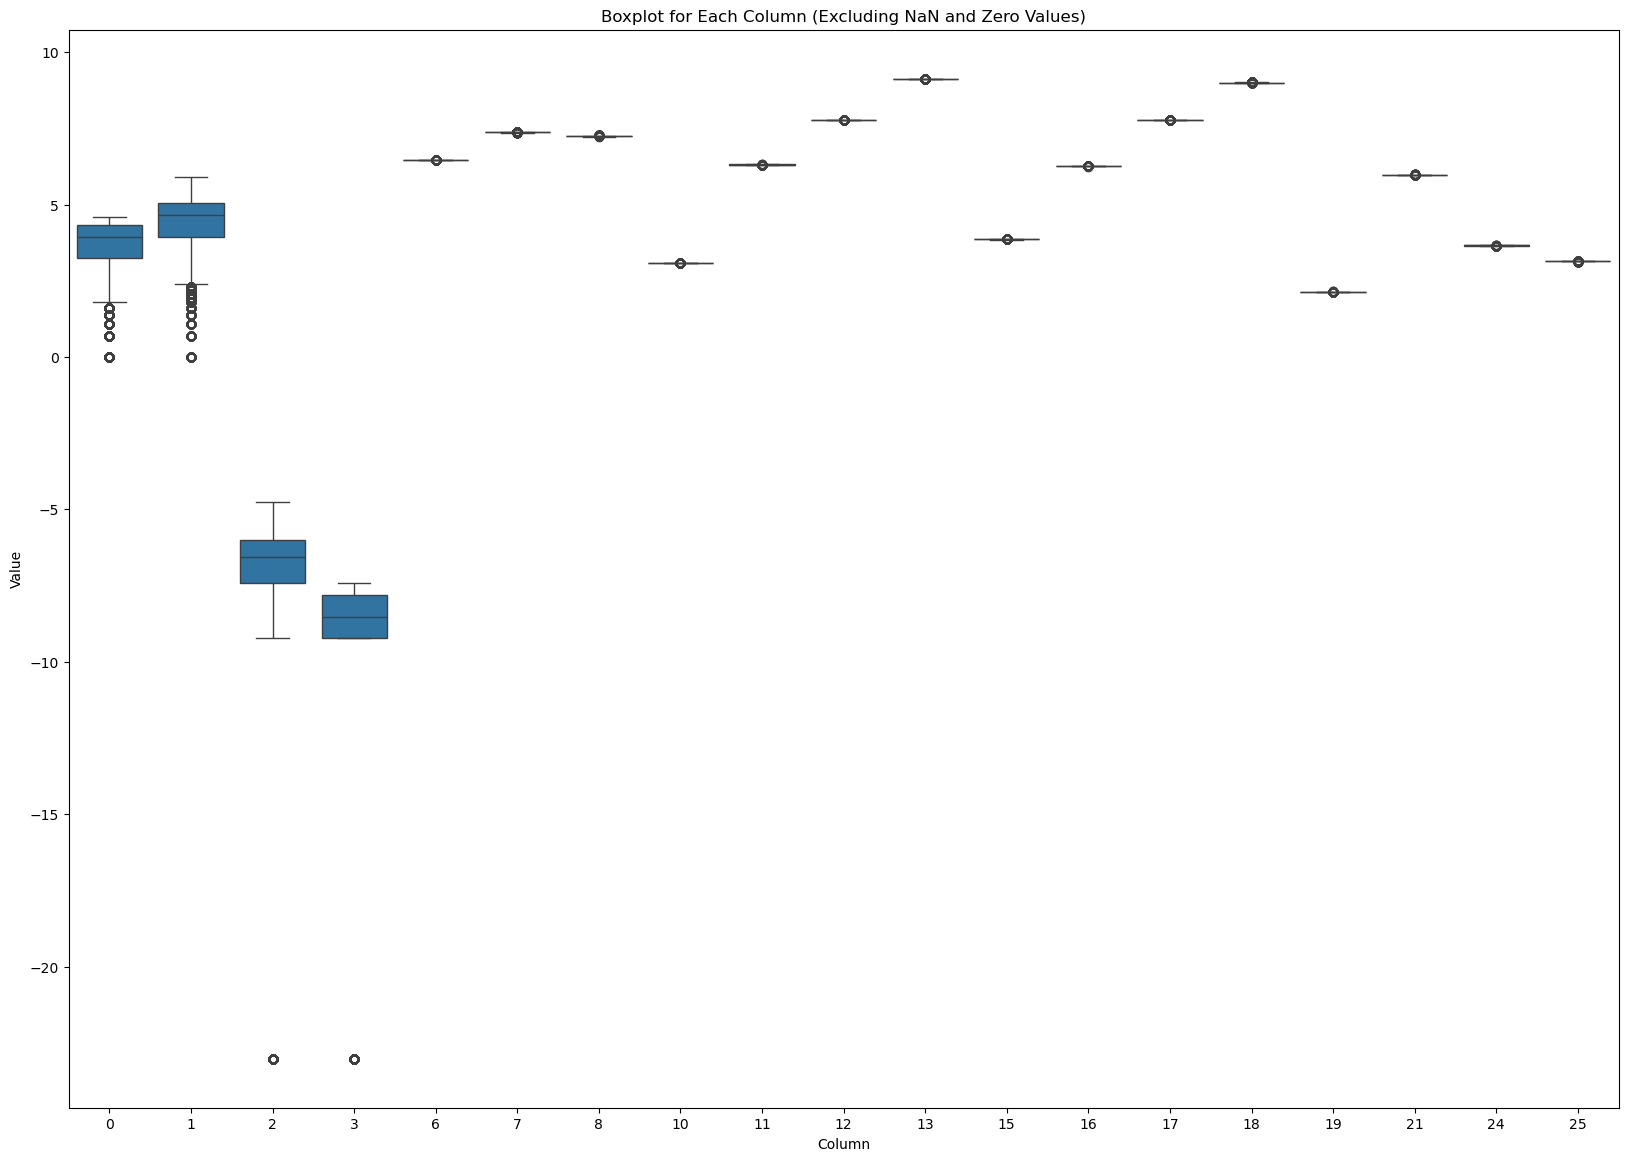

In [14]:

epsilon = 1e-10
df_cleaned = train_df + epsilon
df_log = df_cleaned.map(np.log)
melted_df_cleaned = df_log.melt(var_name='Column', value_name='Value')

plt.figure(figsize=(20, 14))
sns.boxplot(x='Column', y='Value', data=melted_df_cleaned)
plt.title('Boxplot for Each Column (Excluding NaN and Zero Values)')
plt.show()

/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: invalid value encountered in log
  return lib.map_infer(values, mapper, convert=convert)


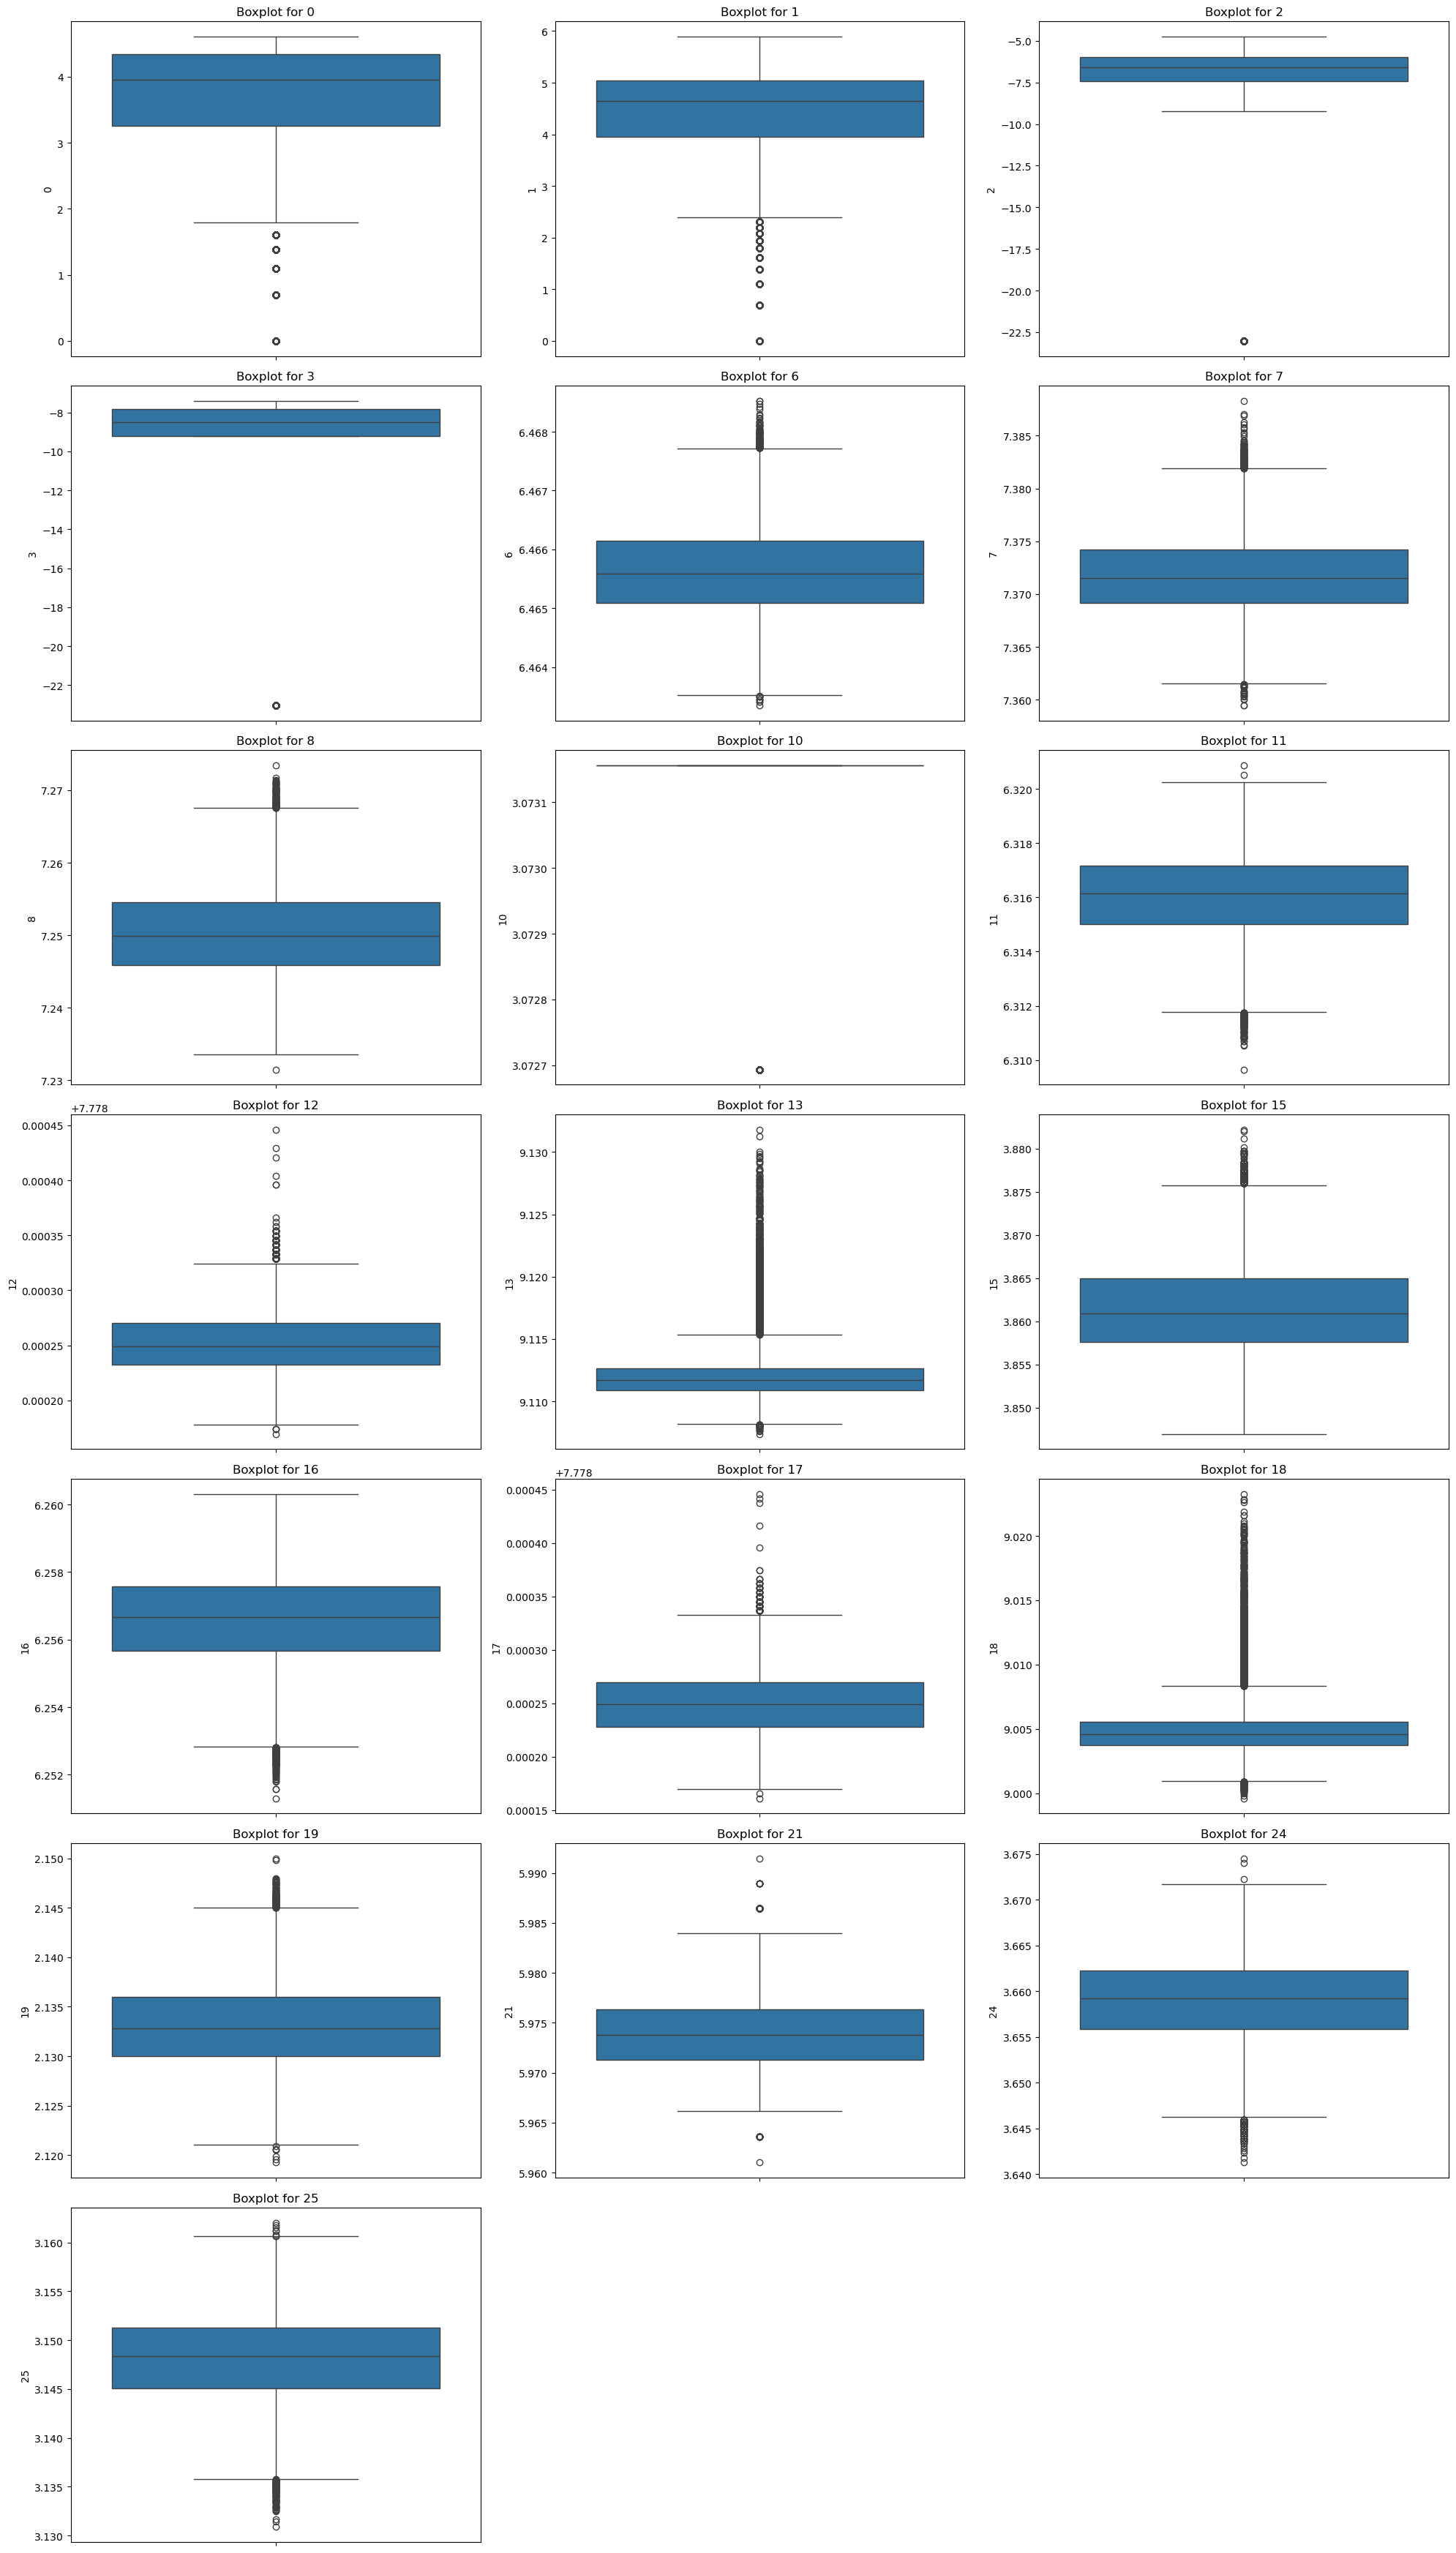

In [15]:
epsilon = 1e-10
df_cleaned = train_df + epsilon
df_log = df_cleaned.map(np.log)


num_columns = df_log.shape[1]
num_rows = (num_columns // 3) + (num_columns % 3 > 0)

fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))

for i, col in enumerate(df_log.columns):
    row = i // 3
    col_idx = i % 3
    sns.boxplot(y=df_log[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot for {col}')

for j in range(i + 1, num_rows * 3):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [16]:
df_result = pd.DataFrame(columns=[0,1])

changes = train_df.iloc[:, 0].ne(train_df.iloc[:, 0].shift()).cumsum()


result_rows = []

for unique_val in changes.unique():
    last_index = changes[changes == unique_val].index[-1]
    result_rows.append({'Case':train_df.iloc[last_index, 0], 'Cycles before failure': train_df.iloc[last_index, 1]})

df_result = pd.DataFrame(result_rows)
df_result

,Case,Cycles before failure
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


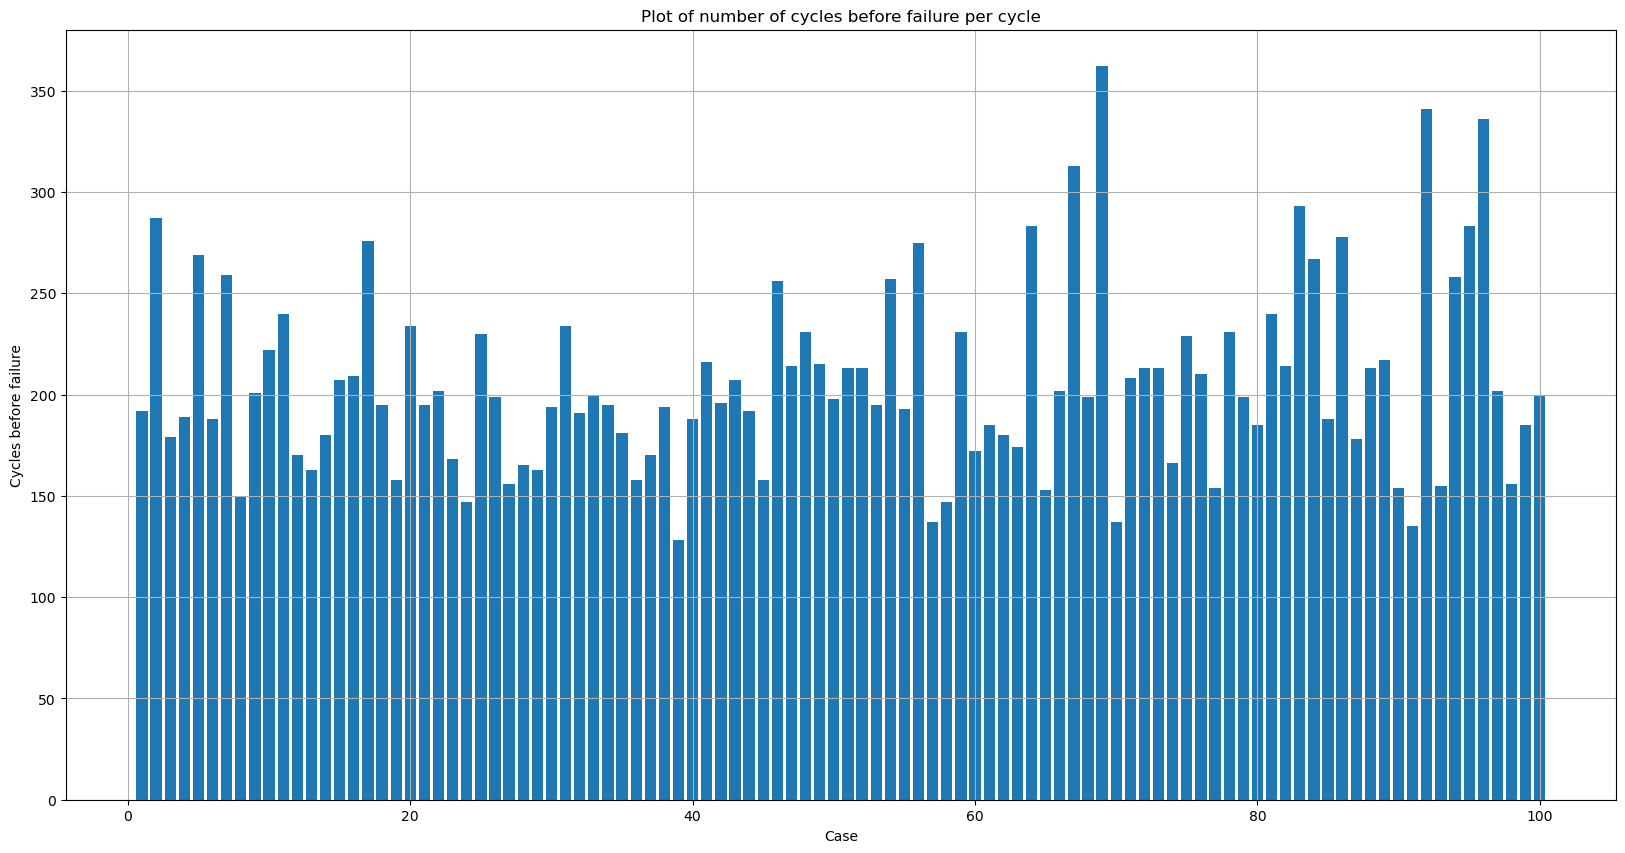

In [17]:
plt.figure(figsize=(20, 10))
plt.bar(df_result['Case'], df_result['Cycles before failure'])

plt.xlabel('Case')
plt.ylabel('Cycles before failure')
plt.title('Plot of number of cycles before failure per cycle')
plt.grid(True)
plt.show()

Correlation matrix 

<Axes: >

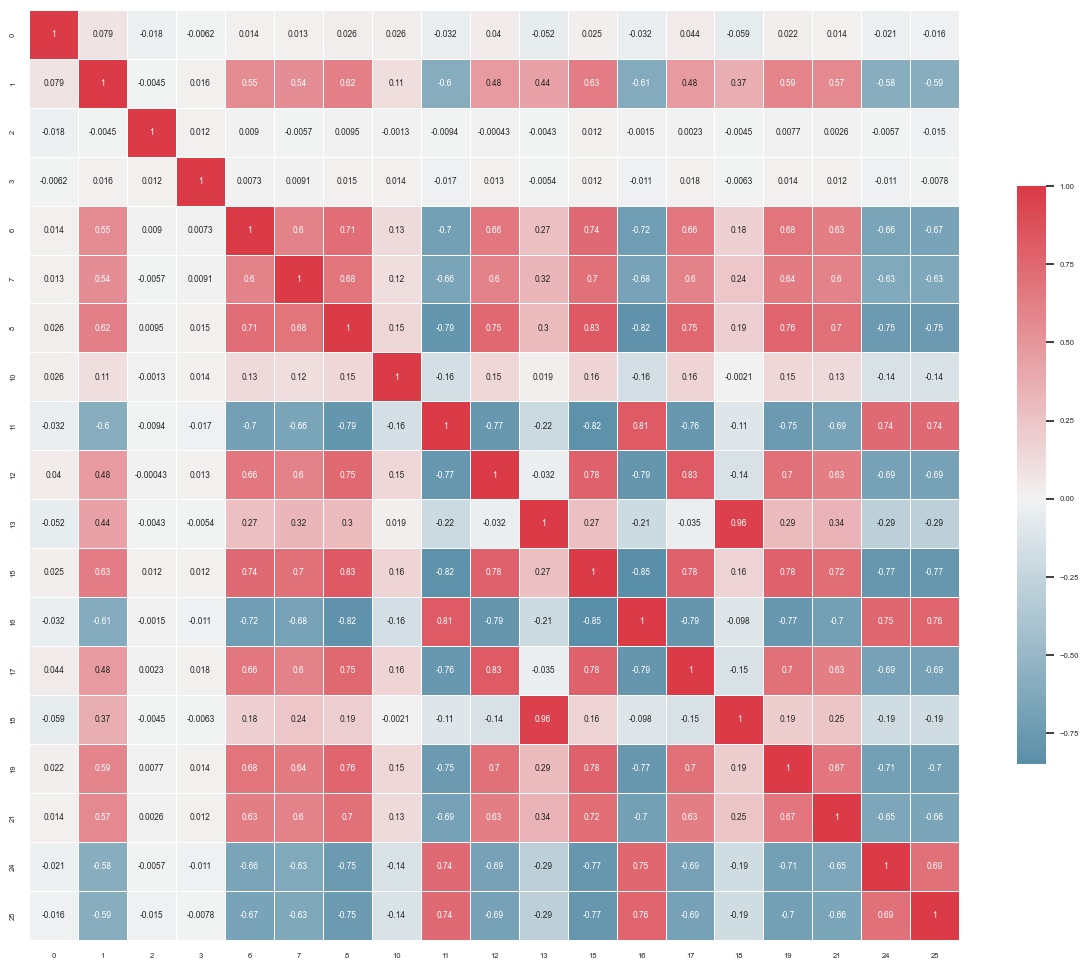

In [18]:
corr = train_df.corr()
sns.set_theme(font_scale=0.5)
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,)

Too many features. K-means doesnt seem to work

In [22]:
# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(train_df)


# inertia = []
# K = range(1, 20)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(train_scaled)
#     inertia.append(kmeans.inertia_)

# plt.figure(figsize=(8, 6))
# plt.plot(K, inertia, 'bo-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method For Optimal k')
# plt.show()



In [23]:

# optimal_k = 15

# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# clusters = kmeans.fit_predict(train_scaled)

# train_df['cluster'] = clusters

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(train_df.iloc[:, 0], train_df.iloc[:, 1], train_df.iloc[:, 2], c=train_df['cluster'], cmap='viridis')

# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)
# ax.set_xlabel('Feature 1')
# ax.set_ylabel('Feature 2')
# ax.set_zlabel('Feature 3')
# plt.title('3D Scatter Plot of Clusters')
# plt.show()

# print(train_df.head())

Let's try to work on predicting 50 cycles before the problem arises so we can notify the engineer

In [29]:
rul = pd.DataFrame(train_df.groupby(0)[1].max()).reset_index()
cycles_before_failue = 50

rul[2] = rul[1] - cycles_before_failue
rul

,0,1,2
0,1,192,142
1,2,287,237
2,3,179,129
3,4,189,139
4,5,269,219
...,...,...,...
95,96,336,286
96,97,202,152
97,98,156,106
98,99,185,135
